# Understanding Problem

## Latar Belakang

Sebagai lulusan Pendidikan Teknik, saya lebih diarahkan untuk menjadi pengajar yang juga memiliki kemampuan Engineering namun melihat realita di lapangan sebagai tenaga pengajar masih kurang dihargai dari segi material dan selain dari persoalan pribadi sehingga saya setelah lulus di Q3 2021 kemarin memutuskan untuk terjun di bidang data. 

Tentu setiap masyarakat di Indonesia memiliki cara pandang yang berbeda-beda terhadap tenaga pengajar, mungkin salah satu tenaga pengajar paling umum kita dengar adalah Guru. Menjadi seorang Guru tetap memerlukan proses yang cukup panjang dan salah satunya dimulai dari Guru Honorer. Menjadi Guru Honorer bukan hal yang mudah jika dilihat dari segi materi, namun teman-teman pengajar diluar sana tetap memilih untuk menjadi Guru honorer

Sehingga berangkat dari kasus tersebut, saya ingin menganalisis sentiment masyarakat terkait guru honorer

## Tujuan 

- Ananlisis bagaimana tanggapan masyarakat terkait guru honorer?
- Apakah permasalahan dari Guru Honorer hanyalah sebatas dari Materi yaitu finansial?

# Import Library

In [65]:
#library & package. 
#Jalankan ulang jika menambahkan library baru

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy, requests
import json, re, string
import seaborn as sns

#crawling data
from bs4 import BeautifulSoup as bs
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import nltk

import requests as rq
#satrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import numpy as np
import tqdm
from nltk.probability import FreqDist

# Data Crawling

## Tweepy

In [33]:
with open("token.json") as f:
    tokens = json.load(f)
    
bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

tokens.keys()

dict_keys(['bearer_token', 'api_key', 'api_key_secret', 'access_token', 'access_token_secret'])

In [34]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
api_2 = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)
searh_key = "guru honorer"

In [35]:
t = []
for tweet in tweepy.Paginator(api_2.search_recent_tweets, query=searh_key, max_results=100, 
                              start_time="2022-04-04T00:00:00Z").flatten():

    #print(len(tweet.text.strip()))
    t.append(tweet.text.strip())


In [36]:
df_1=pd.DataFrame({'Title': t})
df_1.shape

(421, 1)

In [37]:
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.82 Safari/537.36' 


In [38]:
pages = np.arange(1,5)


In [39]:
title = []
for req in pages:
    head = {"User-Agent": user_agent}
    req = rq.get(("https://www.detik.com/search/searchall?query=guru%20honorer&siteid=2&sortby=time&page="+str(req)),headers=head)
    soup = bs(req.text, 'html.parser')
    row= soup.find_all('div', 'list media_rows list-berita')
    #print(row)
    
    for i in row:
        head=i.find("span","box_text")
        judul=head.find("p").text
        title.append(judul)

df_2 = pd.DataFrame({"Title":title})

In [40]:
df_2

,Title
0,Kemenag membutuhkan 242.080 PPPK guru dan dose...
1,Formasi guru ASN PPPK yang disediakan pemerint...
2,Pak Ribut Santoso viral di medsos soal menjela...
3,Video TikTok guru SD di Lumajang Ribut Santoso...


In [41]:
data_tweet = df_1.copy()

In [42]:
data_tweet.shape

(421, 1)

# Data Pre-Processing

In [43]:
def case_folding(text):
    text = text.lower()
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^RT[\s]|(#[A-Za-z0-9]+)"," ",text).split())
    text = text.rstrip()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("","",string.punctuation))
    text = re.sub(r"\n","",text)
    text = re.sub(r"\t","",text)
    text = re.sub(r"^rt[\s]+","",text)
    text = re.sub(r"^#[\s]+","",text)
    text = re.sub(r"https?:\/\/.*[\r\n]*","",text)
    text = re.sub(r"https","",text)
    text = re.sub(r'[^\w\d\s]+', '', text)
    text = re.sub(r"'","",text)
    text = re.sub(r",","",text)
    text = re.sub(r"]","",text)
    
    return text

In [44]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)

def stopword_clean(text):
    sw = stopwords.words("indonesian")
    list_negasi = ['tidak', 'lawan', 'anti', 'bukan', 'belum', 'jangan', 'bukan', 'tak', 'ga']
    sw = [word for word in sw if word not in list_negasi]
    text = [word for word in text if word not in sw]
    result = ' '.join(text)
    return result

In [45]:
def tokeniz(tweet):
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []
    
    for word in tweet_tokens:
        if ( word not in emoticons and# remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
 
    return tweets_clean

In [46]:
def slang_remover(text, slang_list=[]):
    word_list = []
    word_token = word_tokenize(text)
    for word in word_token:
        for slang in slang_list:
            if word.lower() in slang[0].lower():
                word = slang[1]
                break
        word_list.append(word)
    result = ' '.join(word_list)
    return result

In [47]:
data_tweet['Clean Tweet'] = data_tweet['Title'].apply(lambda x: case_folding(x))
data_tweet['Clean Tweet'] = data_tweet['Clean Tweet'].apply(lambda x: tokeniz(x))
data_tweet['Clean Tweet'] = data_tweet['Clean Tweet'].apply(lambda x: stopword_clean(x))

In [48]:
data_tweet

,Title,Clean Tweet
0,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer wa dgn narasi gad...
1,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer wa dgn narasi gad...
2,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer wa dgn narasi gad...
3,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer wa dgn narasi gad...
4,"@inaivatco Coba bayangin, berapa jumlah guru ...",coba bayangin guru honorer kabupaten
...,...,...
416,@pugsemangat3 @dedefirman2014 5. Pemerintah be...,perintah belum maksimal sejahtera ajar guru ho...
417,@_suamiidamanmu @Bayu_Te_ @pugsemangat3 @dedef...,suamiidamanmu te jujur sistem bobrok dana bos ...
418,IDNsee Aktual – 🔴KABAR BAIK..!! USULAN MENARIK...,idnsee aktual kabar usul tarik pppk meuluskan ...
419,@papibenderang @pugsemangat3 @dedefirman2014 y...,ya klo honorer bayar y mikir guru sebenernya d...


In [49]:
def word_freq_dist(data):
    data = data.apply(lambda x: word_tokenize(str(x)))
    tweets = [word for tweet in data for word in tweet]
    fqdist = FreqDist(tweets)
    most = fqdist.most_common(25)
    return most, tweets

In [50]:
most=  word_freq_dist(data_tweet['Clean Tweet'])
print(most[0])

[('guru', 490), ('honorer', 427), ('gaji', 127), ('yg', 75), ('pppk', 68), ('abdi', 60), ('anak', 55), ('tidak', 54), ('motor', 49), ('uang', 47), ('sepeda', 42), ('kerja', 39), ('ganjar', 38), ('sekolah', 37), ('belum', 35), ('bayar', 33), ('semangat', 30), ('ya', 29), ('pns', 28), ('angkat', 26), ('tak', 25), ('a', 24), ('ga', 24), ('hadiah', 24), ('kalo', 23)]


- Terdapat beberapa kata yang termasuk spam 

In [51]:
slang_list = [("ya", ""),
              ("a","",),
              ("seko","sekolah"),
              ("guruhonorer", "guru honorer"),
              ("gue","saya"),
              ("cari",""),
              ("jd","maka")
              ]

In [52]:
data_tweet['Clean Tweet'] = data_tweet['Clean Tweet'].apply(lambda x: slang_remover(x, slang_list))
data_tweet['Clean Tweet'] = data_tweet['Clean Tweet'].apply(lambda x: word_tokenize(x))
data_tweet['Clean Tweet'] = data_tweet['Clean Tweet'].apply(lambda x: stopword_clean(x))

In [53]:
data_tweet

,Title,Clean Tweet
0,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer guru honorer wa d...
1,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer guru honorer wa d...
2,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer guru honorer wa d...
3,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer guru honorer wa d...
4,"@inaivatco Coba bayangin, berapa jumlah guru ...",coba bayangin guru honorer guru honorer kabupaten
...,...,...
416,@pugsemangat3 @dedefirman2014 5. Pemerintah be...,perintah belum maksimal sejahtera ajar guru ho...
417,@_suamiidamanmu @Bayu_Te_ @pugsemangat3 @dedef...,suamiidamanmu te jujur sistem bobrok dana bos ...
418,IDNsee Aktual – 🔴KABAR BAIK..!! USULAN MENARIK...,idnsee aktual kabar usul tarik pppk meuluskan ...
419,@papibenderang @pugsemangat3 @dedefirman2014 y...,klo guru honorer bayar mikir guru honorer sebe...


In [54]:
data_tweet.drop_duplicates(subset="Clean Tweet", keep='first',inplace=True)
data_tweet

,Title,Clean Tweet
0,RT @Rei_Dania: Beredar foto Guru Honorer di WA...,dania edar foto guru honorer guru honorer wa d...
4,"@inaivatco Coba bayangin, berapa jumlah guru ...",coba bayangin guru honorer guru honorer kabupaten
5,#SayaBersamaJokowi kawal sampai 2024. Jangan s...,sayabersamajokowi kawal jangan turun takut gan...
6,RT @PBPGRI_OFFICIAL: Bincang santai yang isiny...,official bincang santai isi daging wasekjen du...
7,@worksfess Guru honorer dan perawat honorer ke...,guru honorer guru honorer awat guru honorer ke...
...,...,...
415,@simplepipel @ranranraneee_ @_suamiidamanmu @u...,suamiidamanmu te sd daerah gw tetep ngadain in...
416,@pugsemangat3 @dedefirman2014 5. Pemerintah be...,perintah belum maksimal sejahtera ajar guru ho...
417,@_suamiidamanmu @Bayu_Te_ @pugsemangat3 @dedef...,suamiidamanmu te jujur sistem bobrok dana bos ...
418,IDNsee Aktual – 🔴KABAR BAIK..!! USULAN MENARIK...,idnsee aktual kabar usul tarik pppk meuluskan ...


# Data Processing

## Analytics

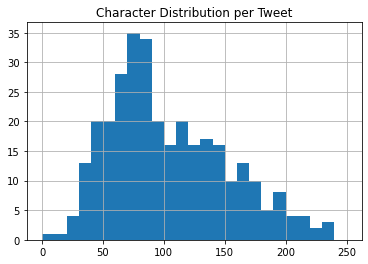

In [55]:
bin_range = np.arange(0, 260, 10)
data_tweet['Clean Tweet'].str.len().hist(bins=bin_range)
plt.title("Character Distribution per Tweet");
plt.show()

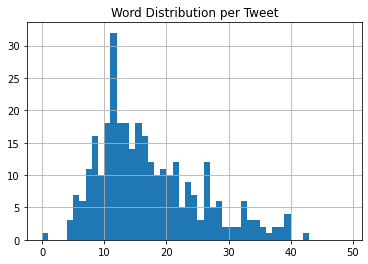

In [56]:
bin_range = np.arange(0, 50)
data_tweet['Clean Tweet'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.title("Word Distribution per Tweet");
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


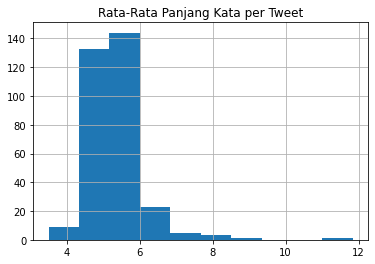

In [57]:
data_tweet['Clean Tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title('Rata-Rata Panjang Kata per Tweet')
plt.show();

In [58]:
data_tweet.drop(data_tweet.columns[[0]], axis = 1, inplace = True)
data_tweet['Clean Tweet 1'] = data_tweet['Clean Tweet'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in data_tweet['Clean Tweet 1'] for word in tweet]
fqdist = FreqDist(tweets)
most = fqdist.most_common(50)

result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
print(result)

(guru, honorer)       752
(honorer, guru)       290
(gaji, guru)           38
(honorer, yg)          20
(pppk, guru)           18
(sepeda, motor)        13
(nasib, guru)          13
(honorer, sekolah)     13
(honorer, gaji)        13
(kota, bogor)          11
(honorer, tidak)       11
(honorer, belum)       10
(sejahtera, guru)      10
(sekolah, negeri)       9
(honorer, tenaga)       9
(tenaga, didik)         8
(anak, anak)            8
(wajib, bayar)          8
(orang, guru)           8
(panggil, disdik)       8
dtype: int64


- Analisis sementara ini adalah:
1. Distribusi karakter dan kata-kata cukup tinggi, selain memberikan opini masyarakat twitter juga memberikan tanggapan dan atau menceritakan hal yang mereka alami (guru honorer)
2. Hubuungan tiap kata dilihat yaitu guru honorer selain tidak didukungnya materi dari pemerintah yang membuat kurangnya kesenjahteraan mereka alami yaitu mereka terkait pemerintah yang menjajikan pengakatan guru honorer menjadi pppk atau pns.

- Didukung dengan laman detik.com:
https://www.detik.com/jabar/berita/d-6009717/16-tahun-mengabdi-guru-honorer-ciamis-ini-diangkat-jadi-p3k
https://www.detik.com/sulsel/berita/d-6009125/harap-harap-cemas-3432-pppk-guru-pemprov-sulsel-tunggu-kepastian-diangkat


## Sentiment

In [59]:
with open("positif.txt","r") as positif_file :
    positive_words = list(set(positif_file.readlines()))
with open("negatif.txt","r") as negative_file :
    negative_words = list(set(negative_file.readlines()))

In [61]:
hasil = []
list_negasi = ['tidak','lawan','anti', 'tdk', 'jangan', 'gak', 'enggak', 'bukan', 'tak']

for tweet in data_tweet['Clean Tweet']:

    tweet_clean = tweet.strip().split()
    
    good_count = 0 #nilai positif
    bad_count = 0 #nilai negatif

    for good_word in positive_words:
        count = tweet_clean.count(good_word.strip().lower())
        if count > 0:
            print(good_word.strip())
            good_count += count

    for bad_word in negative_words:
        count = tweet_clean.count(bad_word.strip().lower())
        if count > 0:
            print(bad_word.strip())
            bad_count += count
    
    print ("positif: "+str(good_count))
    print ("negatif: "+str(bad_count))
    hasil.append(good_count - bad_count)
    print ("-----------------------------------------------------")

fakta
positif: 1
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
takut
turun
positif: 0
negatif: 2
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
remeh
positif: 0
negatif: 1
-----------------------------------------------------
enak
positif: 1
negatif: 0
-----------------------------------------------------
positif: 0
negatif: 0
-----------------------------------------------------
bantu
aneh
positif: 2
negatif: 1
-----------------------------------------------------
fakta
menyalahgunakan
positif: 1
negatif: 1
-----------------------------------------------------
cinta
positif: 1
negatif: 0
-----------------------------------------------------
kompeten
profesional

In [62]:
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
data_tweet["sentiment"] = sentiments

In [63]:
print (f'''
Mean: {np.mean(hasil)}
Median: {np.median(hasil)}
quartil awal: {np.quantile(hasil,0.25)}
quartil akhir: {np.quantile(hasil,0.75)}
Standar deviasi: {np.std(hasil)}     
''')


Mean: 0.515625
Median: 0.0
quartil awal: 0.0
quartil akhir: 1.0
Standar deviasi: 1.4360556602635568     



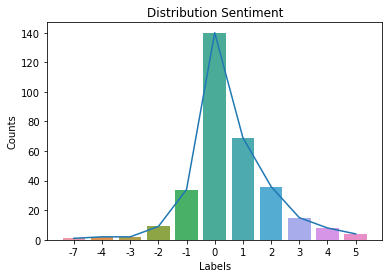

In [66]:
labels, counts = np.unique(hasil, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(ax.get_xticks())

sns.barplot(x = list(labels), 
            y = list(counts))

sns.lineplot(x = ax.get_xticks(), 
            y = list(counts))

plt.title(f'Distribution Sentiment')
plt.xlabel('Labels')
plt.ylabel('Counts')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='sentiment'>

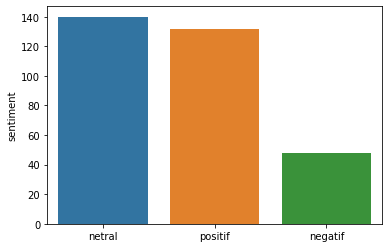

In [68]:
sns.barplot(data_tweet['sentiment'].value_counts().index,data_tweet['sentiment'].value_counts())

1. Dilihat dari distribusi sentiment normal sedikit cenderung ke kiri
2. Masyarakat memberikan opini positif dan netral terhadap guru honorer

# Conclusion

- Ananlisis bagaimana tanggapan masyarakat terkait guru honorer?
- - Tanggapan masyarakat terhadap guru honorer sangatlah baik dilihat dari tanggapan positif lebih banyak
- Apakah permasalahan dari Guru Honorer hanyalah sebatas dari Materi yaitu finansial?
- - Selain materi finansial yang akan memiliki korelasi dengan kesejahteran, masyarakat terutama guru honorer itu sendiri tetap bertahan karena teman-teman tenaga pengajar mempunyai keingin untuk mengabdi sebagai tenaga pendidik, namun mereka juga tetap menuntut hak dan kesejahteraan mereka seabagi guru honorer yang akan di angkat menjadi PNS/PPPK


Menjadi tenaga pengajar adalah pekerjaan mulia yang bertujuan untuk mencerdaskan bangsa, namun ada baiknya pemerintah memperhatikan kesejahteraan guru-guru terutama guru honorer di Indonesia tidak hanya berdalih mengapresiasikan mereka saja melalui kalimat "Guru adalah pahlawan tanpa tanda jasa"

- Pada proyek akhir ini saya rasa tidak diperlukannya menggunakan Machine Learning dikarenakan data yang  didapat masih dapat ditangani tanpa menggunakan machine learning